Load all the filenames, samples, and durations from disk.

In [33]:
import numpy as np
output_dir = 'input/28k'
filenames = np.genfromtxt(output_dir + '/filenames.txt', dtype='str', delimiter='\n')
%time samples = np.load(output_dir + '/samples.npy')
durations = np.genfromtxt(output_dir + '/durations.txt', dtype=np.int)

CPU times: user 11.7 ms, sys: 6.01 s, total: 6.02 s
Wall time: 7.59 s


Calculate the constant-Q transform of the sounds with a given hop_length.

In [12]:
import librosa
cqts = []
for sample in tqdm(samples, ncols=110, leave=True):
    cqt = librosa.cqt(sample, sr=sr, tuning=0, hop_length=8192)
    cqts.append(cqt.flatten('F').astype(np.float32))
cqts = np.array(cqts)

100%|███████████████████████████████████████████████████████████████████| 28488/28488 [07:36<00:00, 62.40it/s]


In [14]:
%time np.save(output_dir + '/cqts.npy', cqts)

CPU times: user 2.17 ms, sys: 71.4 ms, total: 73.6 ms
Wall time: 93.8 ms


In [14]:
%time cqts = np.load(output_dir + '/cqts.npy')

CPU times: user 583 µs, sys: 51.5 ms, total: 52.1 ms
Wall time: 186 ms


The following plots show some statistics and visualizations of the sounds.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

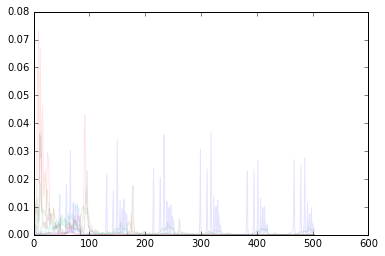

In [15]:
n_plot = 10
plt.plot(cqts[np.random.randint(0, len(cqts), n_plot)].T, alpha=1./n_plot)
plt.show()

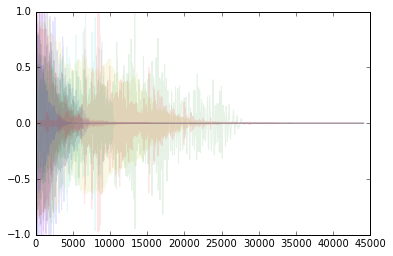

In [67]:
n_plot = 10
plt.plot(samples[np.random.randint(0, len(samples), n_plot)].T, alpha=1./n_plot)
plt.show()

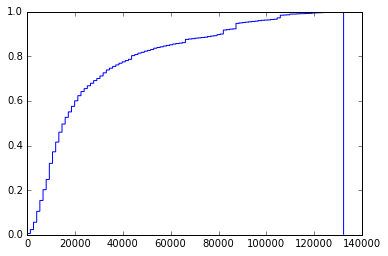

In [16]:
plt.hist(durations, bins=100, histtype='step', cumulative=1, normed=1)
plt.show()

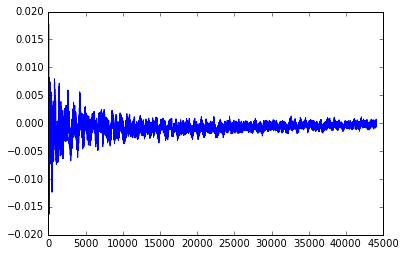

In [18]:
mean = samples.mean(axis=0)
plt.plot(mean)
plt.show()

In [ ]:
import IPython.display
IPython.display.Audio(data=mean, rate=44100)

In [15]:
len(filenames)

28491

In [16]:
samples.shape

(28488, 44100)

In [17]:
cqts.shape

(28488, 504)